## **Câu 2: Classification – Coronavirus tweets NLP (1.0 điểm)**
Use data in covid_text_classification folder to build a model to determine if an 
OriginalTweet is Extremely Negative/ Negative/ Neutral/ Positive/ Extremely Positive.
Read more information here:
https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
!tar xf spark-3.1.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import Tokenizer,StopWordsRemover
from pyspark.ml.feature import CountVectorizer,IDF,StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

from scipy import stats
#from datetime import datetime
import datetime

from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer, OneHotEncoder, Bucketizer, VectorAssembler, StringIndexer
from pyspark.sql.functions import round
from pyspark.sql.window import Window
from functools import reduce

from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import datediff
from pyspark.sql.functions import when
from pyspark.sql import DataFrame

from pyspark.ml.linalg import Vectors


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, LinearSVC
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky


In [ ]:
from pyspark import SparkContext
sc = SparkContext()


In [ ]:
spark = SparkSession(sc)

In [ ]:
df_train = spark.read.csv('data/covid_text_classification/Corona_NLP_train.csv', inferSchema=True, header=True, sep = ',')
df_test = spark.read.csv('data/covid_text_classification/Corona_NLP_test.csv', inferSchema=True, header=True, sep = ',')

## **Phân tích khai phá dữ liệu và tiền xử lý (EDA & Preprocessing)**

In [ ]:
df_train.show(5)

+--------+------------+--------------------+----------+--------------------+---------+
|UserName|  ScreenName|            Location|   TweetAt|       OriginalTweet|Sentiment|
+--------+------------+--------------------+----------+--------------------+---------+
|    3799|       48751|              London|16-03-2020|@MeNyrbie @Phil_G...|  Neutral|
|    3800|       48752|                  UK|16-03-2020|advice Talk to yo...| Positive|
|    3801|       48753|           Vagabonds|16-03-2020|Coronavirus Austr...| Positive|
|    3802|       48754|                null|16-03-2020|My food stock is ...|     null|
|  PLEASE| don't panic| THERE WILL BE EN...|      null|                null|     null|
+--------+------------+--------------------+----------+--------------------+---------+
only showing top 5 rows



In [ ]:
df_test.show(5)

+--------------------+----------+-----------+----------+--------------------+------------------+
|            UserName|ScreenName|   Location|   TweetAt|       OriginalTweet|         Sentiment|
+--------------------+----------+-----------+----------+--------------------+------------------+
|                   1|     44953|        NYC|02-03-2020|TRENDING: New Yor...|Extremely Negative|
|                   2|     44954|Seattle, WA|02-03-2020|When I couldn't f...|          Positive|
|                   3|     44955|       null|02-03-2020|Find out how you ...|Extremely Positive|
|                   4|     44956|Chicagoland|02-03-2020|#Panic buying hit...|              null|
|https://t.co/IASi...|      null|       null|      null|                null|              null|
+--------------------+----------+-----------+----------+--------------------+------------------+
only showing top 5 rows



In [ ]:
df_train.printSchema()

root
 |-- UserName: string (nullable = true)
 |-- ScreenName: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- TweetAt: string (nullable = true)
 |-- OriginalTweet: string (nullable = true)
 |-- Sentiment: string (nullable = true)



In [ ]:
df_train.count()

68046

In [ ]:
df_test.count()

6792

In [ ]:
df_train_pd = df_train.toPandas()

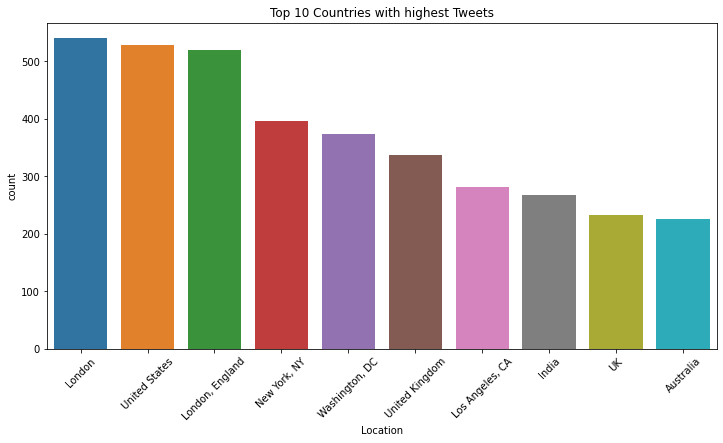

In [ ]:
#Top 10 Countries that had the highest tweets
plt.figure(figsize=(12,6))
plt.title('Top 10 Countries with highest Tweets')
countries =sns.countplot(x='Location', data=df_train_pd, order=df_train_pd['Location'].value_counts().index[:10])
countries.set_xticklabels(countries.get_xticklabels(), rotation=45)
plt.show() 

'''
Nhìn chung thì đây là 10 location có lượng tweets nhiều nhất tương ứng với việc 
tỉ lệ người sử dụng twitter tập trung chính ở USA(new york, washington DC, kis angeles, ...), UK(london, united kingdom, ...).
'''

'''
Dễ thấy, UserName, ScreenName, Location, TweetAt không phải là những field quan trọng trong dataset 
=> ta có thể bỏ nó
'''

In [ ]:
df_train2 = df_train.drop('UserName', 'ScreenName', 'Location', 'TweetAt')
df_test2 = df_test.drop('UserName', 'ScreenName', 'Location', 'TweetAt')

In [ ]:
df_train2.show(5)

df_test2.show(5)

+--------------------+---------+
|       OriginalTweet|Sentiment|
+--------------------+---------+
|@MeNyrbie @Phil_G...|  Neutral|
|advice Talk to yo...| Positive|
|Coronavirus Austr...| Positive|
|My food stock is ...|     null|
|                null|     null|
+--------------------+---------+
only showing top 5 rows

+--------------------+------------------+
|       OriginalTweet|         Sentiment|
+--------------------+------------------+
|TRENDING: New Yor...|Extremely Negative|
|When I couldn't f...|          Positive|
|Find out how you ...|Extremely Positive|
|#Panic buying hit...|              null|
|                null|              null|
+--------------------+------------------+
only showing top 5 rows



In [ ]:
print('Size của df_train', df_train2.count())
print('Size của df_test', df_test2.count())

6792/(68046+6792)

Size của df_train 68046
Size của df_test 6792


0.09075603303134772

In [ ]:
df_train2.printSchema()

df_test2.printSchema()

root
 |-- OriginalTweet: string (nullable = true)
 |-- Sentiment: string (nullable = true)

root
 |-- OriginalTweet: string (nullable = true)
 |-- Sentiment: string (nullable = true)



In [ ]:
'''
Kiểu dữ liệu các cột của df_train và df_test đều là string
Size của df_train 68046
Size của df_test 6792
'''

'\nKiểu dữ liệu các cột của df_train và df_test đều là string\nSize của df_train 68046\nSize của df_test 6792\n'

### **Clean Data**

### **Check missing data**

In [ ]:
df_train2.where(df_train2.Sentiment.isNull()).show(5)

+--------------------+---------+
|       OriginalTweet|Sentiment|
+--------------------+---------+
|My food stock is ...|     null|
|                null|     null|
|                null|     null|
|                null|     null|
|Me, ready to go a...|     null|
+--------------------+---------+
only showing top 5 rows



In [ ]:
'''
Quan sát cấu trúc dữ liệu của 2 file csv, vì format tệ nên sau khi read, dataset có chứa các dữ liệu rác, null ở sentiment 
=> cần xóa chúng đi
'''

'\nQuan sát cấu trúc dữ liệu của 2 file csv, vì format tệ nên sau khi read, dataset có chứa các dữ liệu rác, null ở sentiment \n=> cần xóa chúng đi\n'

In [ ]:
df_train2 = df_train2.where(~df_train2.Sentiment.isNull())
df_test2 = df_test2.where(~df_test2.Sentiment.isNull())

In [ ]:
df_train2.where(df_train2.OriginalTweet.isNull()).show()

+-------------+---------+
|OriginalTweet|Sentiment|
+-------------+---------+
+-------------+---------+



In [ ]:
df_test2.where(df_test2.OriginalTweet.isNull()).show()

+-------------+---------+
|OriginalTweet|Sentiment|
+-------------+---------+
+-------------+---------+



In [ ]:
'''
dataset đẹp hơn hẳn, ko còn các giá trị rác từ cột sentiment => cột OriginalTweet cũng được làm sạch theo.
1 mũi tên trúng 2 con chim.
'''

'\ndataset đẹp hơn hẳn, ko còn các giá trị rác từ cột sentiment => cột OriginalTweet cũng được làm sạch theo.\n1 mũi tên trúng 2 con chim.\n'

In [ ]:
df_train2.select([count(when(isnan(c), c)).alias(c) for c in df_train2.columns]).toPandas().T

,0
OriginalTweet,0
Sentiment,0


In [ ]:
df_test2.select([count(when(isnan(c), c)).alias(c) for c in df_test2.columns]).toPandas().T

,0
OriginalTweet,0
Sentiment,0


In [ ]:
'''
dataset của train và test ko có nan, mừng ghê ^^
'''

'\ndataset của train và test ko có nan, mừng ghê ^^\n'

In [ ]:
df_train2.select([count(when(col(c).isNull(), c)).alias(c) for c in df_train2.columns]).toPandas().T

,0
OriginalTweet,0
Sentiment,0


In [ ]:
df_test2.select([count(when(col(c).isNull(), c)).alias(c) for c in df_test2.columns]).toPandas().T

,0
OriginalTweet,0
Sentiment,0


In [ ]:
'''
dataset đẹp quá đi :))
'''

'\ndataset đẹp quá đi :))\n'

### **Check duplicates**

In [ ]:
total = df_train2.count()
distinct = df_train2.distinct().count()

print('df_train', 'có', total, 'records')
print('df_train', 'có', distinct, 'distinct records')
if total > distinct:
    print('df_train', 'có các duplicate records với ' + str(total - distinct) + ' duplicate records')
else:
    print('df_train', 'ko có duplicate records')

df_train có 28617 records
df_train có 28614 distinct records
df_train có các duplicate records với 3 duplicate records


In [ ]:
'''
df_train có duplicate => xóa đi nàooo
'''

'\ndf_train có duplicate => xóa đi nàooo\n'

In [ ]:
df_train2 = df_train2.drop_duplicates()
df_train2.count()

28614

In [ ]:
total = df_test2.count()
distinct = df_test2.distinct().count()

print('df_test', 'có', total, 'records')
print('df_test', 'có', distinct, 'distinct records')
if total > distinct:
    print('df_test', 'có các duplicate records với ' + str(total - distinct) + ' duplicate records')
else:
    print('df_test', 'ko có duplicate records')

df_test có 2533 records
df_test có 2533 distinct records
df_test ko có duplicate records


In [ ]:
'''
Mừng ghê, df_test không có duplicate
'''

'\nMừng ghê, df_test không có duplicate\n'

### **Phân tích các biến**

In [ ]:
df_train_pd2 = df_train2.toPandas()
df_test_pd2 = df_test2.toPandas()

In [ ]:
def check_duplicate(df, column):
    total = df[[column]].count()
    distinct = df[[column]].distinct().count()

    print(column, 'có', total, 'records')
    print(column, 'có', distinct, 'distinct records')
    if total > distinct:
        print(column, 'có các duplicate records với ' + str(total - distinct) + ' duplicate records')
    else:
        print(column, 'ko có duplicate records')

In [ ]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

### **Sentiment**

In [ ]:
df_train2.groupBy('Sentiment').count().show(10)


+--------------------+-----+
|           Sentiment|count|
+--------------------+-----+
|              #virus|    1|
| only a few preli...|    1|
| consumer and mor...|    1|
| Vaccines and Tre...|    1|
| potatoes &amp; v...|    1|
|    online education|    1|
|      Mumbai or Pune|    1|
| spot the scams""...|    1|
| claiming the new...|    1|
|"" as shoppers ac...|    1|
+--------------------+-----+
only showing top 10 rows



In [ ]:
'''
Về cơ bản, chỉ có 5 giá trị là Extremely Negative, Negative, Neutral, Positive, Extremely Positive
=> tất cả các giá trị còn lại đều là rác hếttt (các giá trị rác là các giá trị xuất hiện 1 lần)
'''

'\nVề cơ bản, chỉ có 5 giá trị là Extremely Negative, Negative, Neutral, Positive, Extremely Positive\n=> tất cả các giá trị còn lại đều là rác hếttt (các giá trị rác là các giá trị xuất hiện 1 lần)\n'

In [ ]:
df_train3 = df_train2.filter((df_train2.Sentiment.like('Extremely Negative')) | (df_train2.Sentiment.like('Negative')) |
(df_train2.Sentiment.like('Neutral')) | (df_train2.Sentiment.like('Positive')) | (df_train2.Sentiment.like('Extremely Positive'))
)
df_train3.show()

+--------------------+------------------+
|       OriginalTweet|         Sentiment|
+--------------------+------------------+
|So supermarket ch...|Extremely Negative|
|Smiths Food &amp...|          Positive|
|Theres no reaso...|          Negative|
|Dear genius count...|Extremely Positive|
|Coronavirus Updat...|          Negative|
|Repurposed Soviet...|          Negative|
|News you can use ...|          Negative|
|The retail store ...|          Negative|
|Why is there stil...|          Positive|
|Thank you to ALL ...|Extremely Positive|
|Hoarding Please S...|Extremely Negative|
|rwanda will still...|Extremely Positive|
|@trentbartonland ...|           Neutral|
|If we try our bes...|Extremely Positive|
|I see that respon...|           Neutral|
|COVID-19 quaranti...|          Negative|
|Everyone that s  ...|          Positive|
|I was six years o...|          Positive|
|Supermarket intro...|          Negative|
|Just spending thi...|           Neutral|
+--------------------+------------

In [ ]:
df_train3.count()

27962

In [ ]:
'''
=> data đã dc dọn sạch
'''

'\n=> data đã dc dọn sạch\n'

In [ ]:
# làm tương tự cho df_test
df_test3 = df_test2.filter((df_test2.Sentiment.like('Extremely Negative')) | (df_test2.Sentiment.like('Negative')) |
(df_test2.Sentiment.like('Neutral')) | (df_test2.Sentiment.like('Positive')) | (df_test2.Sentiment.like('Extremely Positive'))
)

In [ ]:
'''
Về cơ bản, dataset for test đã được làm sạch các giá trị null, rác lúc read file do cấu trúc data của file khá tệ.
'''

'\nVề cơ bản, dataset for test đã được làm sạch các giá trị null, rác lúc read file do cấu trúc data của file khá tệ.\n'

In [ ]:
df_train3.groupBy('Sentiment').count().show()

+------------------+-----+
|         Sentiment|count|
+------------------+-----+
|Extremely Negative| 3751|
|          Positive| 7718|
|           Neutral| 5224|
|          Negative| 6857|
|Extremely Positive| 4412|
+------------------+-----+



In [ ]:
df_train_pd3 = df_train3.toPandas()

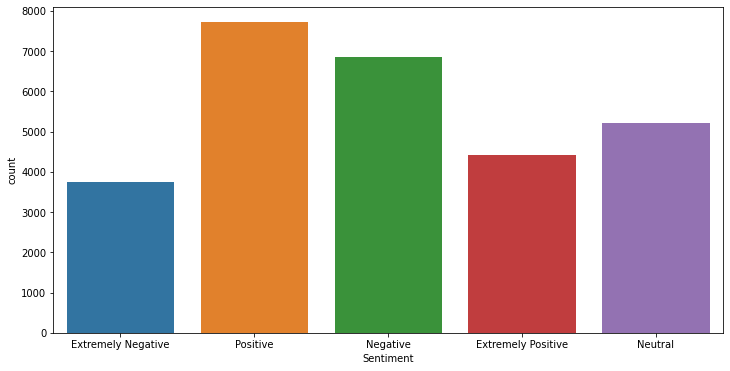

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
#plt.xticks(rotation=45)
ax = sns.countplot(x = df_train_pd3.Sentiment)
plt.show()

'''
Nhìn chung, có sự lệch nhẹ giữa các giá trị của Sentiments
vd: Extremely Negative có 3751 records nhưng Positive có tới 7718 records.
=> model sau khi build có thể có score không cao.
Có thể cân nhắc việc nhập chung các nhóm lại, thay vì 5 nhóm thì thành 3 nhóm (positive - neutral - negative) 
hay thậm chí là 2 nhóm (positive - negative)
'''

### **OriginalTweet**

In [ ]:
check_duplicate(df_train3, 'OriginalTweet')

OriginalTweet có 27962 records
OriginalTweet có 27962 distinct records
OriginalTweet ko có duplicate records


In [ ]:
df_train_pd3.columns

Index(['OriginalTweet', 'Sentiment'], dtype='object')

#### **Tiền xử lý text cho wordcloud**

In [ ]:
# download stopwords
nltk.download("stopwords")
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# df_train_pd3["OriginalTweet"] = df_train_pd3['OriginalTweet'].apply(lambda x: x.lower())

In [ ]:
# def clean_data(text):
#     text = str(text).strip()
#     text = text.replace("?","")
#     text = re.sub(r"http\S+","",text)
#     text = re.sub(r"@\w+","",text)
#     text = re.sub(r"#\w+","",text)
#     text = re.sub(r"\d+","",text)
#     text = re.sub(r"<.*?>","",text)
#     text = text.split()
#     text = " ".join([word for word in text if not word in stop_words])
#     #text - str(text).strip()
#     return text.encode('ascii',errors='ignore')

In [ ]:
from nltk.corpus.reader import reviews
from nltk.stem.porter import PorterStemmer
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

def preprocessor(text):
    #remove urls
    tweet1= re.sub(r'http\S+', ' ', text)
    #remove html tags
    tweet2 = re.sub(r'<.*?>',' ', tweet1) 
    #remove digits
    tweet3 = re.sub(r'\d+',' ', tweet2)
    #remove hashtags
    tweet4 = re.sub(r'#\w+',' ', tweet3)
    review = re.sub('[^a-zA-Z]', ' ', tweet4)
    review = review.lower()
    # review = review.split()
    # ps = PorterStemmer()
    # review = [ps.stem(word) for word in review if word not in all_stopwords]
    #review = ' '.join(review)
    return review

In [ ]:
df_train_pd3["New_OriginalTweet"] = df_train_pd3['OriginalTweet'].apply(lambda x : preprocessor(x))

In [ ]:
df_train_pd3

,OriginalTweet,Sentiment,New_OriginalTweet
0,So supermarket checkout staff cannot handle pe...,Extremely Negative,so supermarket checkout staff cannot handle pe...
1,Smiths Food &amp;amp; Drug Stores today annou...,Positive,smith s food amp amp drug stores today annou...
2,"Theres no reason to hoard. In Italy, were a...",Negative,there s no reason to hoard in italy we re a...
3,Dear genius countrymen and women. Soap works b...,Extremely Positive,dear genius countrymen and women soap works b...
4,"Coronavirus Update: Supply Chain, Food Shortag...",Negative,coronavirus update supply chain food shortag...
...,...,...,...
27957,Disney pass prices going down cause of the #co...,Negative,disney pass prices going down cause of the o...
27958,@WAGSocialCare @WAGSocialCare your Walgreens w...,Extremely Positive,wagsocialcare wagsocialcare your walgreens w...
27959,TIGHTER SECURITY. Grounded from stringent poli...,Positive,tighter security grounded from stringent poli...
27960,Just to stay on the safe side I randomly drink...,Extremely Positive,just to stay on the safe side i randomly drink...


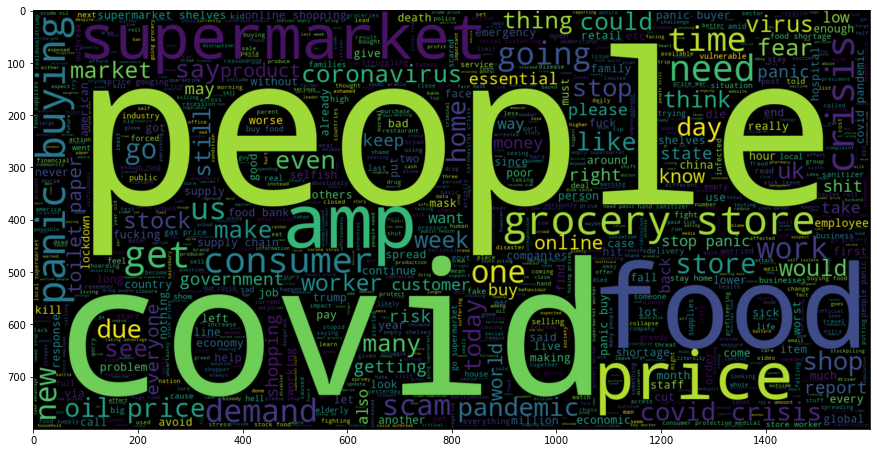

In [ ]:
# df_train_pd3_new = df_train_pd3[['New_OriginalTweet', 'Sentiment']]

# word cloud các text có Sentiment là Extremely Negative
plt.figure(figsize = (15,18)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words)\
    .generate(" ".join(df_train_pd3[df_train_pd3.Sentiment == 'Extremely Negative'].New_OriginalTweet))

plt.imshow(wc, interpolation = 'bilinear')
plt.show()

'''
Ngoài các đặc điểm chung giữa các Sentiemnt như covid, food, price, ...
thì còn có các từ mang hàm ý bộc lộ cảm xúc mạnh (như shit, ...)
'''

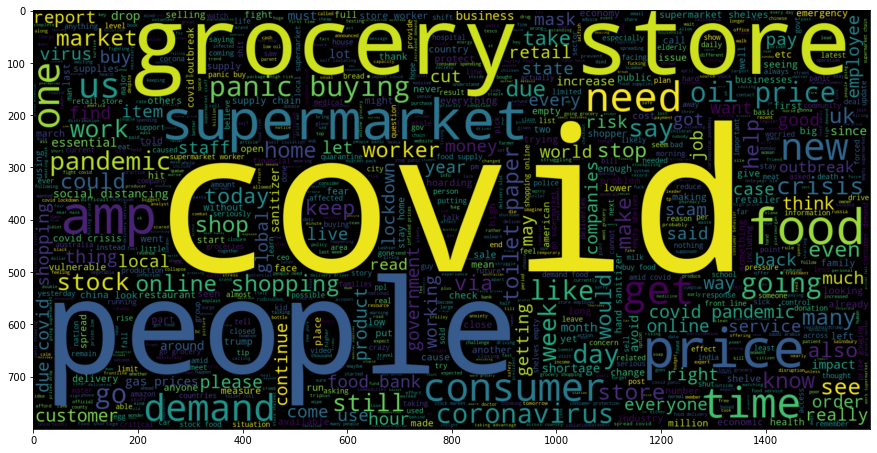

In [ ]:
# word cloud các text có Sentiment là Negative
plt.figure(figsize = (15,18)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words)\
    .generate(" ".join(df_train_pd3[df_train_pd3.Sentiment == 'Negative'].New_OriginalTweet))

plt.imshow(wc, interpolation = 'bilinear')
plt.show()

'''
Ngoài các đặc điểm chung giữa các Sentiemnt như covid, food, price, ...
thì có nhóm Negative có các từ đặc trưng như oil price, ... (do giá dầu xuống mức âm vào thời điểm bùng dịch, chả bù cho bây giờ gần 30k 1l xăng, huhu). 
'''

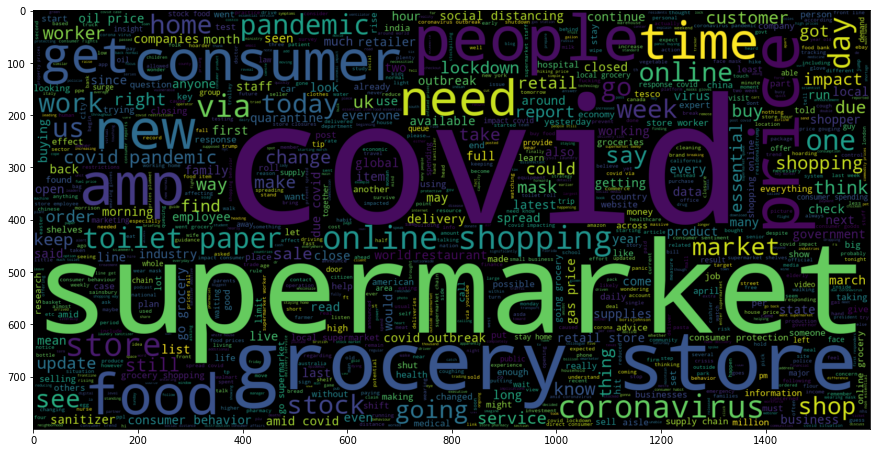

In [ ]:
# word cloud các text có Sentiment là Neutral
plt.figure(figsize = (15,18)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words)\
    .generate(" ".join(df_train_pd3[df_train_pd3.Sentiment == 'Neutral'].New_OriginalTweet))

plt.imshow(wc, interpolation = 'bilinear')
plt.show()

'''
Vẫn là covid và supermarket thôi
'''

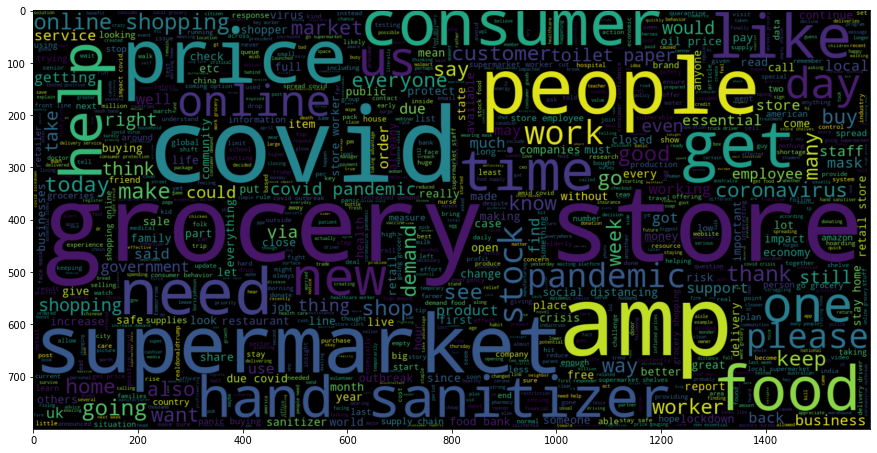

In [ ]:
# word cloud các text có Sentiment là Positive
plt.figure(figsize = (15,18)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words)\
    .generate(" ".join(df_train_pd3[df_train_pd3.Sentiment == 'Positive'].New_OriginalTweet))

plt.imshow(wc, interpolation = 'bilinear')
plt.show()

'''
''' Vẫn là covid và supermarket thôi '''
'''

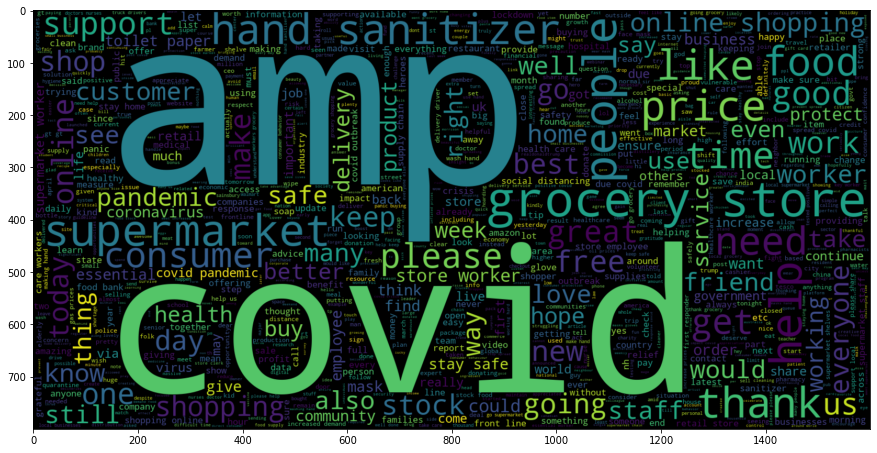

In [ ]:
# word cloud các text có Sentiment là Extremely Positive
plt.figure(figsize = (15,18)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words)\
    .generate(" ".join(df_train_pd3[df_train_pd3.Sentiment == 'Extremely Positive'].New_OriginalTweet))

plt.imshow(wc, interpolation = 'bilinear')
plt.show()

'''
Nhìn chung, cho dù là Sentiment nào thì cũng đều xoay quanh giữa các key words:
Covid, food, price, market, delivery, keep, ...
Do trong thời kỳ dịch bệnh covid, các hoạt động bị hạn chế và giá cả thức ăn tăng lên, ...
'''

In [ ]:
df_test_pd3 = df_test3.toPandas()

In [ ]:
df_test_pd3["New_OriginalTweet"] = df_test_pd3['OriginalTweet'].apply(lambda x : preprocessor(x))

In [ ]:
df_test_pd3.head(5)

,OriginalTweet,Sentiment,New_OriginalTweet
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermar...
1,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldn t find hand sanitizer at fred me...
2,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...
3,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,news newsmelb one ...
4,Do you remember the last time you paid $2.99 a...,Neutral,do you remember the last time you paid a ...


In [ ]:
df_train4 = spark.createDataFrame(df_train_pd3)

In [ ]:
df_test4 = spark.createDataFrame(df_test_pd3)

In [ ]:
# lưu lại để đề phòng server bị đứt kết nối còn có cái để sử dụng, ko cần phải run lại từ đầu :)
df_train4.write.parquet('Exercise2/train_dataset.parquet', mode = 'overwrite')
df_test4.write.parquet('Exercise2/test_dataset.parquet', mode = 'overwrite')

In [ ]:
df_train4 = spark.read.parquet('Exercise2/train_dataset.parquet')
df_test4 = spark.read.parquet('Exercise2/test_dataset.parquet')

### **Feature Transformations**

'''
dataset sau khi phân tích và xử lý, về cơ bản sẽ có 2 field:
- OriginalTweet hoặc New_OriginalTweet (predict) :là OriginalTweet sau khi đã tiền xử lý text): kiểu string
- Sentiment (target): category variable 

'''

In [ ]:
# xử lý data dạng text của new_text_join
tokenizer = Tokenizer(inputCol="New_OriginalTweet", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")

# xử lý cột Sentiment
class_to_num = StringIndexer(inputCol='Sentiment', outputCol='label')


In [ ]:
assembler = VectorAssembler(inputCols=['tf_idf'], outputCol='features')

### **Pipeline**

In [ ]:
data_prep_pipe = Pipeline(stages=[tokenizer, stopremove, count_vec, idf, class_to_num, assembler])

In [ ]:
df_train4.columns

['OriginalTweet', 'Sentiment', 'New_OriginalTweet']

In [ ]:
df_train5 = df_train4[['New_OriginalTweet', 'Sentiment']]
df_test5 = df_test4[['New_OriginalTweet', 'Sentiment']]

In [ ]:
df_union = df_train5.union(df_test5) 
# gộp là để pipline transformation cho cả train và test, 
# sau đó sẽ lấy đúng các records của training và testing giống như trong 2 file train và test

In [ ]:
# cleaner_train = data_prep_pipe.fit(df_train5)
# cleaner_test = data_prep_pipe.fit(df_test5)

cleaner = data_prep_pipe.fit(df_union)

In [ ]:
# clean_data_train = cleaner_train.transform(df_train5)
# clean_data_test = cleaner_test.transform(df_test5)

clean_data = cleaner.transform(df_union)

### **Chuẩn bị dữ liệu train - test**

In [ ]:
# clean_data_train = clean_data_train.select(['label','features'])
# clean_data_test = clean_data_test.select(['label','features'])

clean_data = clean_data.select(['label','features'])

In [ ]:
#df_train3.groupBy('Sentiment').count().show()

In [ ]:
#clean_data_train.show(10) 
clean_data.show(10)


+-----+--------------------+
|label|            features|
+-----+--------------------+
|  4.0|(33712,[0,1,2,3,5...|
|  0.0|(33712,[0,1,3,8,1...|
|  1.0|(33712,[0,3,5,13,...|
|  3.0|(33712,[0,2,3,6,1...|
|  1.0|(33712,[0,3,18,28...|
|  1.0|(33712,[0,1,10,11...|
|  1.0|(33712,[0,57,67,9...|
|  1.0|(33712,[0,1,2,24,...|
|  0.0|(33712,[0,4,17,50...|
|  3.0|(33712,[0,3,8,13,...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
'''
label: 0 là Positive, 1 là Negative, 2 là Neutral, 3 là Extremely Positive, 4 là Extremely Negative
'''

'\nlabel: 0 là Positive, 1 là Negative, 2 là Neutral, 3 là Extremely Positive, 4 là Extremely Negative\n'

In [ ]:
# clean_data_train.filter(col('label') == 0).count()
clean_data.filter(col('label') == 0).count()

8325

In [ ]:
# clean_data_train.filter(col('label') == 1).count()
clean_data.filter(col('label') == 1).count()

7532

In [ ]:
# clean_data_train.filter(col('label') == 2).count()
clean_data.filter(col('label') == 2).count()

5652

In [ ]:
# clean_data_train.filter(col('label') == 3).count()
clean_data.filter(col('label') == 3).count()

4795

In [ ]:
# clean_data_train.filter(col('label') == 4).count()
clean_data.filter(col('label') == 4).count()

4129

In [ ]:
df_train4.count()

27962

In [ ]:
df_test4.count()

2471

In [ ]:
# training = clean_data_train
# testing = clean_data_test

## (training, testing) = clean_data.randomSplit([0.7,0.3])

# training = clean_data.limit(27962)
# testing = clean_data.subtract(training)

In [ ]:
# row_list = clean_data.collect()

# part1 = row_list[:27962]
# part2 = row_list[27962:]


# training = spark.createDataFrame(part1)
# testing = spark.createDataFrame(part2)

In [ ]:
# part1 = clean_data.head(27962)
# part2 = clean_data.tail(2471)
# training = spark.createDataFrame(part1)
# testing = spark.createDataFrame(part2)

In [ ]:
clean_data_new = clean_data.withColumn('id', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)

In [ ]:
training = clean_data_new.filter(col('id') < 27962).drop('id')
testing = clean_data_new.filter((col('id') >= 27962) & (col('id') < (27962 + 2471))).drop('id')

In [ ]:
training.count()

27962

In [ ]:
testing.count()

2471

In [ ]:
'''
=> vẫn đảm bảo dc training và test là các data lấy từ 2 file train và test từ yêu cầu đề
'''

'\n=> vẫn đảm bảo dc training và test là các data lấy từ 2 file train và test từ yêu cầu đề\n'

In [ ]:
training.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  4.0| 3751|
|  0.0| 7718|
|  1.0| 6857|
|  3.0| 4412|
|  2.0| 5224|
+-----+-----+



In [ ]:
training.describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|             27962|
|   mean|1.6288176811386883|
| stddev| 1.380564468981618|
|    min|               0.0|
|    max|               4.0|
+-------+------------------+



In [ ]:
testing.groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|  0.0|  607|
|  3.0|  383|
|  2.0|  428|
|  4.0|  378|
|  1.0|  675|
+-----+-----+



In [ ]:
testing.describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|              2471|
|   mean| 1.696479158235532|
| stddev|1.3897192459127055|
|    min|               0.0|
|    max|               4.0|
+-------+------------------+



'''
Nhìn chung, do sự chênh lệch số lượng giữa các nhóm (vd như trong training_dataset, Extremely Negative có 3751 records 
nhưng Positive có tới 7718 records
=>model sau khi build có thể có score không cao.
Có thể cân nhắc việc nhập chung các nhóm lại, thay vì 5 nhóm thì thành 3 nhóm (positive - neutral - negative) 
hay thậm chí là 2 nhóm (positive - negative)

giá trị std của train và test đều nhỏ
'''

In [ ]:
# lưu lại để đề phòng server bị đứt kết nối
training.write.parquet('Exercise2/training.parquet', mode = 'overwrite')
testing.write.parquet('Exercise2/testing.parquet', mode = 'overwrite')

In [ ]:
training = spark.read.parquet('Exercise2/training.parquet')
testing = spark.read.parquet('Exercise2/testing.parquet')

### **Xây dựng model**
Chúng ta chọn một vài thuật toán classification:
- Logistics Regression
- Native Bayes
- Decision Tree
- SVC
- Random Forest

In [ ]:
def classification_model_evalution(model_fited, data_train, data_test):
    test_results = model_fited.transform(data_test)

    #Create a confusion matrix
    print('Confusion matrix:')
    test_results.groupBy('label', 'prediction').count().show(5)

    # acc score
    acc_eval = MulticlassClassificationEvaluator()
    acc = acc_eval.evaluate(test_results)

    TN = test_results.filter('prediction = 0 AND label = prediction').count()
    TP = test_results.filter('prediction = 1 AND label = prediction').count()
    FN = test_results.filter('prediction = 0 AND label != prediction').count()
    FP = test_results.filter('prediction = 1 AND label != prediction').count()

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    # acc = (TP+TN)/(TP+TN+FP+FN)

    print('Accuracy: ', acc)
    print('Precision: ', precision)
    print('Recall: ', recall)


### **Logistics Regression**

In [ ]:
lr = LogisticRegression()

In [ ]:
start_time_logistic_reg = datetime.datetime.now()
predictor = lr.fit(training)
end_time_logistic_reg = datetime.datetime.now()

In [ ]:
logistic_runtime = end_time_logistic_reg - start_time_logistic_reg
logistic_runtime.total_seconds()

28.146345

In [ ]:
test_results = predictor.transform(testing)


In [ ]:
test_results.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(33712,[0,1,3,11,...|[18.9428413796395...|[5.53746786974878...|       1.0|
|  3.0|(33712,[0,14,28,4...|[45.6004298182728...|[5.49091992485885...|       3.0|
|  0.0|(33712,[0,2,6,17,...|[125.934906587004...|[1.0,1.6898642324...|       0.0|
|  2.0|(33712,[0,3,124,2...|[44.2249230209531...|[0.12991708087551...|       1.0|
|  4.0|(33712,[0,2,6,13,...|[-53.063578329198...|[4.36933587452313...|       1.0|
|  0.0|(33712,[0,23,28,5...|[-39.817561107714...|[1.08849051056970...|       1.0|
|  4.0|(33712,[0,1,3,18,...|[-83.519820110727...|[3.97871322673395...|       1.0|
|  4.0|(33712,[0,3,10,14...|[1.93037976916710...|[1.88938801988439...|       4.0|
|  2.0|(33712,[0,316,716...|[7.60284372995810...|[0.02874509536319...|       1.0|
|  2.0|(33712,[5

#### **Đánh giá**

In [ ]:
classification_model_evalution(predictor, training, testing)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|  145|
|  3.0|       3.0|  166|
|  0.0|       0.0|  251|
|  2.0|       1.0|  101|
|  4.0|       1.0|  177|
+-----+----------+-----+
only showing top 5 rows

Accuracy:  0.422996767619847
Precision:  0.38791946308724834
Recall:  0.4053295932678822


In [ ]:
'''
score thấp 
=> đổi thuật toán khác!
'''

### **Random Forest**

In [ ]:
rf = RandomForestClassifier()

In [ ]:
start_time_rf = datetime.datetime.now()
predictor_5 = rf.fit(training)
end_time_rf = datetime.datetime.now()

In [ ]:
runtime_rf = end_time_rf - start_time_rf
runtime_rf.total_seconds()

79.868976

In [ ]:
classification_model_evalution(predictor_5, training, testing)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  606|
|  3.0|       0.0|  383|
|  2.0|       0.0|  428|
|  4.0|       0.0|  362|
|  1.0|       0.0|  668|
+-----+----------+-----+
only showing top 5 rows

Accuracy:  0.10295882569603311
Precision:  0.2916666666666667
Recall:  0.003787878787878788


In [ ]:
'''
score thấp 
=> đổi thuật toán khác!
'''

'\nscore thấp \n=> đổi thuật toán khác!\n'

### **Decision Tree**

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
start_time_dt = datetime.datetime.now()
predictor_3 = dt.fit(training)
end_time_dt = datetime.datetime.now()

In [ ]:
runtime_dt = end_time_dt - start_time_dt
runtime_dt.total_seconds()

99.373443

In [ ]:
predictor_3.transform(testing).show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(33712,[0,1,3,11,...|[6360.0,5717.0,50...|[0.28198989092843...|       0.0|
|  3.0|(33712,[0,14,28,4...|[156.0,504.0,32.0...|[0.12283464566929...|       4.0|
|  0.0|(33712,[0,2,6,17,...|[6360.0,5717.0,50...|[0.28198989092843...|       0.0|
|  2.0|(33712,[0,3,124,2...|[6360.0,5717.0,50...|[0.28198989092843...|       0.0|
|  4.0|(33712,[0,2,6,13,...|[156.0,504.0,32.0...|[0.12283464566929...|       4.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
classification_model_evalution(predictor_3, training, testing)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  522|
|  3.0|       4.0|   25|
|  2.0|       0.0|  413|
|  4.0|       4.0|  135|
|  0.0|       3.0|   39|
+-----+----------+-----+
only showing top 5 rows

Accuracy:  0.1984420708745846
Precision:  0.25
Recall:  0.0006784260515603799


In [ ]:
'''
score thấp 
=> đổi thuật toán khác!
'''

'''
Nhìn chung, sau khi thử 3 thuật toán ta thấy đều cho ra score thấp => khả năng cao các thuật toán khác cũng sẽ thấp!
Có thể là do sự mất cân bằng trong các nhóm trong dataset.
Vì vậy, ta thử gom nhóm lại thay vì 5 nhóm như ban đầu là extremely_positive - neutral - negative - extremely_negative
thì ta có thể thành 3 nhóm (positive - neutral - negative) 
hay thậm chí là 2 nhóm (positive - negative)

Ở đây, ta sẽ thử reshaping trước, nếu score model thấp thì ta sẽ tiến hành gom 5 nhóm thành 3 nhóm 
'''

#### **resample data nàooo**

In [ ]:
# label: 0 là Positive, 1 là Negative, 2 là Neutral, 3 là Extremely Positive, 4 là Extremely Negative


In [ ]:
training.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  4.0| 3751|
|  0.0| 7718|
|  1.0| 6857|
|  3.0| 4412|
|  2.0| 5224|
+-----+-----+



In [ ]:
positive_df = training.filter(col('label') == 0)
negative_df = training.filter(col('label') == 1)
neutral_df = training.filter(col('label') == 2)
ex_positive_df = training.filter(col('label') == 3)
ex_negative_df = training.filter(col('label') == 4)

ratio_negative = int(positive_df.count()/negative_df.count())
ratio_neutral = int(positive_df.count()/neutral_df.count())
ratio_ex_positive = int(positive_df.count()/ex_positive_df.count())
ratio_ex_negative = int(positive_df.count()/ex_negative_df.count())

print(ratio_negative, ratio_neutral, ratio_ex_positive, ratio_ex_negative)

1 1 1 2


In [ ]:
#resample ex_negative
a1 = range(ratio_ex_negative)

# duplicate the minority rows
oversampled_ex_negative_df = ex_negative_df.withColumn("dummy", explode(array([lit(x) for x in a1]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
combined_df = positive_df.unionAll(oversampled_ex_negative_df)
combined_df.show(10)


+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(33712,[0,1,3,8,1...|
|  0.0|(33712,[0,4,17,50...|
|  0.0|(33712,[0,1,3,14,...|
|  0.0|(33712,[0,2,6,17,...|
|  0.0|(33712,[0,6,9,10,...|
|  0.0|(33712,[0,1,2,6,1...|
|  0.0|(33712,[0,2,6,7,1...|
|  0.0|(33712,[0,5,17,20...|
|  0.0|(33712,[0,5,8,12,...|
|  0.0|(33712,[0,1,3,20,...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
combined_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7718|
|  4.0| 7502|
+-----+-----+



In [ ]:

dfs = [combined_df, negative_df, neutral_df, ex_positive_df]
training = reduce(DataFrame.unionAll, dfs)

In [ ]:
training.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7718|
|  1.0| 6857|
|  4.0| 7502|
|  3.0| 4412|
|  2.0| 5224|
+-----+-----+



### **Xây dựng model với NaiveBayes**

In [ ]:
nb = NaiveBayes()
start_time_nb = datetime.datetime.now()
predictor_2 = nb.fit(training)
end_time_nb = datetime.datetime.now()

In [ ]:
runtime_nb = end_time_nb - start_time_nb
runtime_nb.total_seconds()

15.537153

In [ ]:
test_results_2 = predictor_2.transform(testing)
test_results_2.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(33712,[0,1,3,11,...|[-898.51041711727...|[2.75659761857993...|       1.0|
|  3.0|(33712,[0,14,28,4...|[-892.54943649815...|[0.43790239865921...|       3.0|
|  0.0|(33712,[0,2,6,17,...|[-1566.4643907603...|[1.0,1.4152104592...|       0.0|
|  2.0|(33712,[0,3,124,2...|[-864.68457051612...|[0.99999976570526...|       0.0|
|  4.0|(33712,[0,2,6,13,...|[-749.50917770541...|[1.40585880290254...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



#### **Đánh giá**

In [ ]:
classification_model_evalution(predictor_2, training, testing)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|  133|
|  3.0|       3.0|  206|
|  0.0|       0.0|  198|
|  2.0|       0.0|   65|
|  4.0|       1.0|  136|
+-----+----------+-----+
only showing top 5 rows

Accuracy:  0.4104779515072008
Precision:  0.397196261682243
Recall:  0.4351535836177474


In [ ]:
'''
Vẫn thấp!
'''

'\nVẫn thấp!\n'

In [ ]:
lr = LogisticRegression()

start_time_logistic_reg = datetime.datetime.now()
predictor = lr.fit(training)
end_time_logistic_reg = datetime.datetime.now()

In [ ]:
logistic_runtime = end_time_logistic_reg - start_time_logistic_reg
logistic_runtime.total_seconds()

61.499915

In [ ]:
test_results = predictor.transform(testing)
test_results.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(33712,[0,1,3,11,...|[11.5006565771331...|[1.97342395139920...|       1.0|
|  3.0|(33712,[0,14,28,4...|[38.2210710112485...|[2.00735868514287...|       3.0|
|  0.0|(33712,[0,2,6,17,...|[103.907092927608...|[1.0,1.3941642503...|       0.0|
|  2.0|(33712,[0,3,124,2...|[39.6910100866460...|[0.60707810949062...|       0.0|
|  4.0|(33712,[0,2,6,13,...|[-35.659513203353...|[3.74647687477985...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



### **Đánh giá**

In [ ]:
classification_model_evalution(predictor, training, testing)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|  139|
|  3.0|       3.0|  162|
|  0.0|       0.0|  258|
|  2.0|       0.0|   88|
|  4.0|       1.0|  164|
+-----+----------+-----+
only showing top 5 rows

Accuracy:  0.4158432411139712
Precision:  0.38088445078459343
Recall:  0.3739495798319328


In [ ]:
'''
Ta build thử 2 thuật toán đều cho ra score thấp là do vẫn có sự chênh lệch giữa các nhóm
=> các thuật toán khác khả năng cao cũng cho ra kết quả như vậy nên ta sẽ gom thành 3 nhóm thay vì 5 nhóm.
'''

'\nTa build thử 2 thuật toán đều cho ra score thấp là do vẫn có sự chênh lệch giữa các nhóm\n=> các thuật toán khác khả năng cao cũng cho ra kết quả như vậy nên ta sẽ gom thành 3 nhóm thay vì 5 nhóm.\n'

### **Gom thành 3 nhóm**

In [ ]:
# label: 0 là Positive, 1 là Negative, 2 là Neutral, 3 là Extremely Positive, 4 là Extremely Negative
training.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(33712,[0,1,3,8,1...|
|  0.0|(33712,[0,4,17,50...|
|  0.0|(33712,[0,1,3,14,...|
|  0.0|(33712,[0,2,6,17,...|
|  0.0|(33712,[0,6,9,10,...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
training2 = training.withColumn('label', when(training.label == 3, 0)
                                    .when(training.label == 4, 1) 
                                    .otherwise(training.label)
)

testing2 = testing.withColumn('label', when(testing.label == 3, 0)
                                    .when(testing.label == 4, 1) 
                                    .otherwise(testing.label)
)

In [ ]:
training2.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|12130|
|  1.0|10608|
|  2.0| 5224|
+-----+-----+



In [ ]:
testing2.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  990|
|  1.0| 1053|
|  2.0|  428|
+-----+-----+



In [ ]:
training2.count()

27962

In [ ]:
positive_df = training2.filter(col('label') == 0)
negative_df = training2.filter(col('label') == 1)
neutral_df = training2.filter(col('label') == 2)

ratio_positive = int(positive_df.count()/negative_df.count())
ratio_neutral = int(positive_df.count()/neutral_df.count())

print(ratio_positive, ratio_neutral)

1 2


In [ ]:
#resample ex_negative
a1 = range(ratio_neutral)

# duplicate the minority rows
oversampled_neutral_df = neutral_df.withColumn("dummy", explode(array([lit(x) for x in a1]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
combined_df = positive_df.unionAll(oversampled_neutral_df)
combined_df.show(10)


+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(33712,[0,1,3,8,1...|
|  0.0|(33712,[0,2,3,6,1...|
|  0.0|(33712,[0,4,17,50...|
|  0.0|(33712,[0,3,8,13,...|
|  0.0|(33712,[8,10,21,5...|
|  0.0|(33712,[0,157,165...|
|  0.0|(33712,[0,1,3,14,...|
|  0.0|(33712,[0,2,6,17,...|
|  0.0|(33712,[0,6,9,10,...|
|  0.0|(33712,[0,1,2,6,1...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
combined_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|12130|
|  2.0|10448|
+-----+-----+



In [ ]:
dfs = [combined_df, negative_df]
training2 = reduce(DataFrame.unionAll, dfs)

In [ ]:
training2.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|12130|
|  1.0|10608|
|  2.0|10448|
+-----+-----+



In [ ]:
'''
Cân bằng hơn rồi nè ^^
'''

'\nCân bằng hơn rồi nè ^^\n'

In [ ]:
# lưu lại đề phòng :))
training2.write.parquet('Exercise2/training_new_3.parquet', mode = 'overwrite')
testing2.write.parquet('Exercise2/testing_new_3.parquet', mode = 'overwrite')

In [ ]:
training2 = spark.read.parquet('Exercise2/training_new_3.parquet')
testing2 = spark.read.parquet('Exercise2/testing_new_3.parquet')

---
-----

### **Xây dựng model mới với 3 nhóm (positive - neutral - negative)**
Chúng ta chọn một vài thuật toán classification:
- Logistics Regression
- Native Bayes
- Decision Tree
- Random Forest

### **Xây dựng model với Logistic Regression**

In [ ]:
lr = LogisticRegression()

In [ ]:
start_time_logistic_reg = datetime.datetime.now()
predictor = lr.fit(training2)
end_time_logistic_reg = datetime.datetime.now()

In [ ]:
logistic_runtime = end_time_logistic_reg - start_time_logistic_reg
logistic_runtime.total_seconds()

38.000066

In [ ]:
test_results = predictor.transform(testing2)
test_results.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(33712,[0,1,3,11,...|[-12.849170641730...|[1.11087720326038...|       1.0|
|  0.0|(33712,[0,14,28,4...|[86.2263408809768...|[1.0,1.2582885094...|       0.0|
|  0.0|(33712,[0,2,6,17,...|[73.1281302905895...|[1.0,3.8102600823...|       0.0|
|  2.0|(33712,[0,3,124,2...|[34.7468651779834...|[1.0,2.1856625634...|       0.0|
|  1.0|(33712,[0,2,6,13,...|[-76.168808353214...|[2.17483380922124...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



#### **Đánh giá**

In [ ]:
classification_model_evalution(predictor, training2, testing2)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  104|
|  1.0|       1.0|  731|
|  0.0|       1.0|  172|
|  2.0|       2.0|  222|
|  1.0|       0.0|  208|
+-----+----------+-----+
only showing top 5 rows

Accuracy:  0.6765585533567309
Precision:  0.727363184079602
Recall:  0.700862895493768


'''
Ơn trời, nó cao hơn rồi :))

Nhìn chung thì score của model sau khi thu gọn label lại thành 3 nhóm có tốt hơn (nhưng vẫn ko dc cao)
đó là do số records neutral bị lệch hơn so với positive và negative
chúng ta thử thuật toán khác xem có tốt hơn không
'''

### **Xây dựng model với NaiveBayes**

In [ ]:
nb = NaiveBayes()

In [ ]:
start_time_nb = datetime.datetime.now()
predictor_2 = nb.fit(training2)
end_time_nb = datetime.datetime.now()


In [ ]:
runtime_nb = end_time_nb - start_time_nb
runtime_nb.total_seconds()

9.102805

In [ ]:
test_results_2 = predictor_2.transform(testing2)
test_results_2.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(33712,[0,1,3,11,...|[-903.76782445862...|[3.32528653606792...|       1.0|
|  0.0|(33712,[0,14,28,4...|[-884.29717948716...|[1.0,2.0811912930...|       0.0|
|  0.0|(33712,[0,2,6,17,...|[-1591.4304571329...|[1.0,1.4835532757...|       0.0|
|  2.0|(33712,[0,3,124,2...|[-882.31397683138...|[0.99999999807972...|       0.0|
|  1.0|(33712,[0,2,6,13,...|[-748.14480267208...|[1.14905778948186...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



#### **Đánh giá**

In [ ]:
classification_model_evalution(predictor_2, training2, testing2)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   96|
|  1.0|       1.0|  754|
|  0.0|       1.0|  272|
|  2.0|       2.0|  212|
|  1.0|       0.0|  215|
+-----+----------+-----+
only showing top 5 rows

Accuracy:  0.6448879654315465
Precision:  0.6579406631762653
Recall:  0.707981220657277


In [ ]:
'''
score khá ổn so với các model khác (nhưng vẫn ko dc cao)
'''

'\nscore khá ổn (nhưng vẫn ko dc cao)\n'

### **Xây dựng model với Decision Tree Classifier**

In [ ]:
dt = DecisionTreeClassifier()

start_time_dt = datetime.datetime.now()
predictor_3 = dt.fit(training2)
end_time_dt = datetime.datetime.now()

In [ ]:
runtime_dt = end_time_dt - start_time_dt
runtime_dt.total_seconds()

92.962715

In [ ]:
predictor_3.transform(testing2).show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(33712,[0,1,3,11,...|[8732.0,7849.0,10...|[0.32707794883320...|       2.0|
|  0.0|(33712,[0,14,28,4...| [203.0,1237.0,50.0]|[0.13624161073825...|       1.0|
|  0.0|(33712,[0,2,6,17,...|  [929.0,306.0,84.0]|[0.70432145564821...|       0.0|
|  2.0|(33712,[0,3,124,2...|[8732.0,7849.0,10...|[0.32707794883320...|       2.0|
|  1.0|(33712,[0,2,6,13,...| [203.0,1237.0,50.0]|[0.13624161073825...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



#### **Đánh giá**

In [ ]:
classification_model_evalution(predictor_3, training2, testing2)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|    8|
|  1.0|       1.0|  247|
|  0.0|       1.0|   63|
|  2.0|       2.0|  409|
|  1.0|       0.0|   86|
+-----+----------+-----+
only showing top 5 rows

Accuracy:  0.37091245743954315
Precision:  0.7694704049844237
Recall:  0.7243401759530792


In [ ]:
'''
Vẫn thấp
'''

'\nVẫn thấp\n'

### **Xây dựng model với với Random Forest**

In [ ]:
rf = RandomForestClassifier()

start_time_rf = datetime.datetime.now()
predictor_5 = rf.fit(training2)
end_time_rf = datetime.datetime.now()

In [ ]:
runtime_rf = end_time_rf - start_time_rf
runtime_rf.total_seconds()

80.183758

In [ ]:
predictor_5.transform(testing2).show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(33712,[0,1,3,11,...|[7.20049882704430...|[0.36002494135221...|       0.0|
|  0.0|(33712,[0,14,28,4...|[7.05553265008688...|[0.35277663250434...|       0.0|
|  0.0|(33712,[0,2,6,17,...|[7.24138977150641...|[0.36206948857532...|       0.0|
|  2.0|(33712,[0,3,124,2...|[7.24138977150641...|[0.36206948857532...|       0.0|
|  1.0|(33712,[0,2,6,13,...|[7.05553265008688...|[0.35277663250434...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
classification_model_evalution(predictor_5, training2, testing2)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|  425|
|  1.0|       1.0|   86|
|  0.0|       1.0|   22|
|  1.0|       0.0|  966|
|  2.0|       2.0|    3|
+-----+----------+-----+
only showing top 5 rows

Accuracy:  0.29714553791970666
Precision:  0.7962962962962963
Recall:  0.05822613405551794


In [ ]:
'''
Thấp quá :((
'''

'\nSau khi build 4/5\n'

## **Đánh Giá**

'''
Nhìn chung, khi build model với label gồm 5 nhóm Positive, Negative, Neutral, Extremely Positive, Extremely Negative
cho score thấp.
Sau khi reshaping lại thì model có cải thiện nhưng không đáng là bao.

Tiếp đó, em gộp  Extremely Positive vào positive,  Extremely Negative vào negative,
từ 5 nhóm trở thành 3 nhóm. 
model có cải thiện hơn, lên tới ~70% đối với thuật toán logistics regression.
Nếu tiếp tục gom nhóm lại (còn 2 nhóm là Positive và Negative) thì model có khả năng sẽ có score cao hơn.
Ngoài ra, nếu kết hợp với hyper parameters và boosting thì score của model sẽ dc tăng cao hơn nữa

***Tuy nhiên, vì giới hạn về thời gian và tài nguyên và qua đánh giá của em thì với score ~70% là ổn rồi
=> chọn thuật toán logistics cho dataset này (dataset có label sau khi gom lại là Positive, Negative, Neutral)

'''

### **Lưu model**

In [ ]:
predictor.save('Exercise2/ex2_logistic_reg_model')

In [ ]:
model_lr = LogisticRegressionModel.load('Exercise2/ex2_logistic_reg_model')